In [42]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from timeit import default_timer as timer
from scipy.integrate import odeint
from scipy.optimize import fsolve
from scipy.stats import norm, kurtosis, skew, linregress
from scipy.signal import resample, decimate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression,  SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, SparsePCA, IncrementalPCA, KernelPCA, TruncatedSVD, SparsePCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import fetch_20newsgroups_vectorized, load_digits
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.random_projection import SparseRandomProjection, johnson_lindenstrauss_min_dim
import collections
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Análisis Exploratorio de los Datos

In [4]:
with open('../sensored_signals/B0xx_sensored_signals/' + 'B001.pkl', 'rb') as f:
    df = pickle.load(f)
df

,simulation_time,unit_id,health state,time,iMotor_meas,wMotor_meas,Q_in_meas,Q_out_meas,P_in_meas,P_out_meas,failure_mode,RUL
0,0.0,B001,1,1,26.009681,1914.819221,46.366914,40.696032,-0.195604,7.167262,None,1278
1,0.001,B001,1,1,26.011225,1913.859966,48.452263,40.993132,-0.200155,7.169959,None,1278
2,0.002,B001,1,1,26.004378,1913.266172,48.979805,39.377896,-0.204692,7.16726,None,1278
3,0.003,B001,1,1,26.02438,1912.855383,50.130968,38.851845,-0.204714,7.161758,None,1278
4,0.004,B001,1,1,26.046448,1912.949424,49.056717,37.548887,-0.203715,7.153532,None,1278
...,...,...,...,...,...,...,...,...,...,...,...,...
1278995,1278.995,B001,0,1279,27.818671,1275.140915,26.419141,26.654138,-0.108819,7.113303,WornBearing,0
1278996,1278.996,B001,0,1279,27.81168,1274.593523,25.974102,26.723339,-0.109629,7.11227,WornBearing,0
1278997,1278.997,B001,0,1279,27.798529,1274.280639,26.478765,26.911653,-0.112847,7.11365,WornBearing,0
1278998,1278.998,B001,0,1279,27.785134,1273.927426,26.715822,26.749988,-0.111929,7.112828,WornBearing,0


In [5]:
df.iloc[:,4:5]

,iMotor_meas
0,26.009681
1,26.011225
2,26.004378
3,26.02438
4,26.046448
...,...
1278995,27.818671
1278996,27.81168
1278997,27.798529
1278998,27.785134


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279000 entries, 0 to 1278999
Data columns (total 12 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   simulation_time  1279000 non-null  object
 1   unit_id          1279000 non-null  object
 2   health state     1279000 non-null  int64 
 3   time             1279000 non-null  object
 4   iMotor_meas      1279000 non-null  object
 5   wMotor_meas      1279000 non-null  object
 6   Q_in_meas        1279000 non-null  object
 7   Q_out_meas       1279000 non-null  object
 8   P_in_meas        1279000 non-null  object
 9   P_out_meas       1279000 non-null  object
 10  failure_mode     1279000 non-null  object
 11  RUL              1279000 non-null  object
dtypes: int64(1), object(11)
memory usage: 117.1+ MB


In [7]:
df[list(df.columns[4:-2])] = df[list(df.columns[4:-2])].astype(float)

In [8]:
df.describe()

,health state,iMotor_meas,wMotor_meas,Q_in_meas,Q_out_meas,P_in_meas,P_out_meas
count,1.279000e+06,1.279000e+06,1.279000e+06,1.279000e+06,1.279000e+06,1.279000e+06,1.279000e+06
mean,3.745113e-01,2.969818e+01,1.866476e+03,3.885916e+01,3.718297e+01,-1.615417e-01,7.155485e+00
std,4.839967e-01,4.526455e+00,1.387254e+02,6.740117e+00,4.030305e+00,2.796043e-02,1.669307e-02
min,0.000000e+00,2.599235e+01,1.271164e+03,2.229326e+01,1.954306e+01,-2.119436e-01,7.080520e+00
25%,0.000000e+00,2.623130e+01,1.911493e+03,3.399523e+01,3.557348e+01,-1.907117e-01,7.148798e+00
50%,0.000000e+00,2.712987e+01,1.914000e+03,3.492189e+01,3.867397e+01,-1.452945e-01,7.161493e+00
75%,1.000000e+00,3.247257e+01,1.916188e+03,4.588802e+01,4.030044e+01,-1.413509e-01,7.168458e+00
max,1.000000e+00,4.173312e+01,1.918912e+03,5.115831e+01,4.217312e+01,-9.393502e-02,7.177143e+00


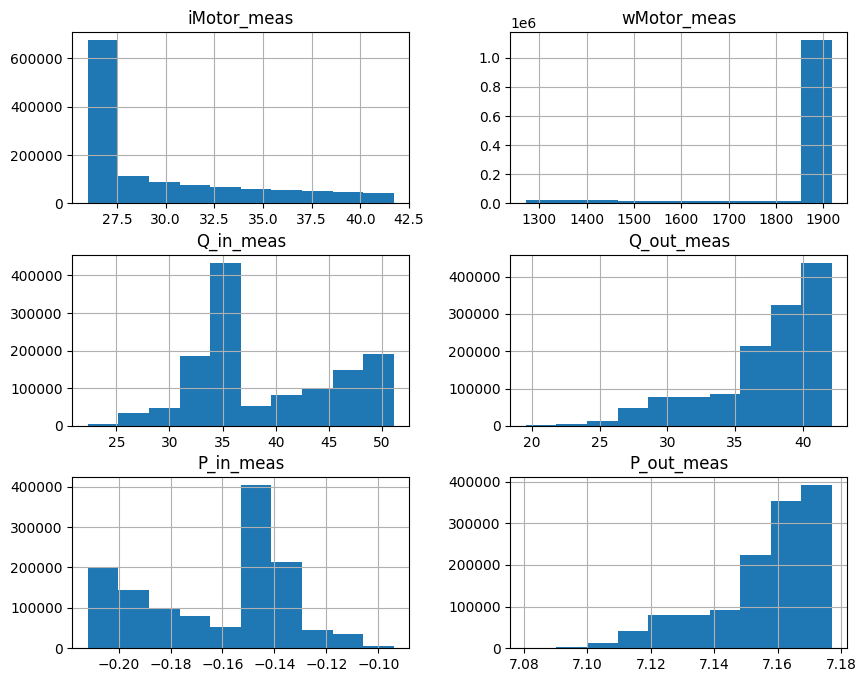

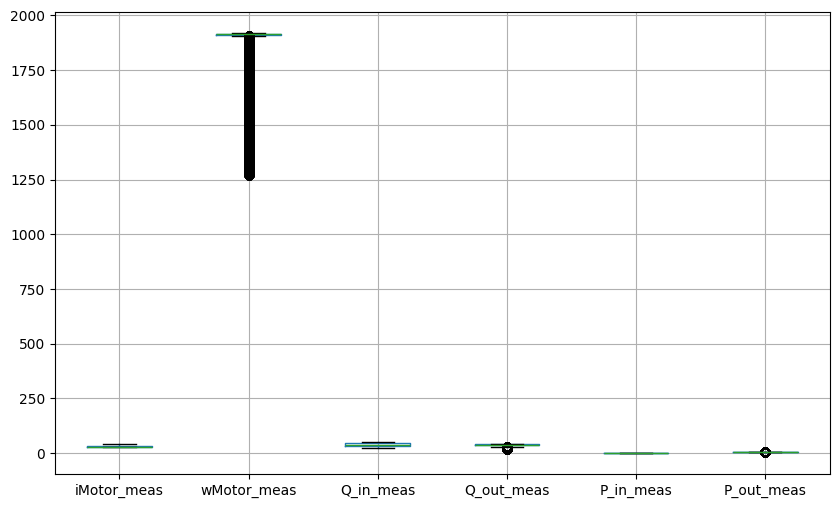

In [9]:
df[list(df.columns[4:-2])].hist(figsize=(10, 8))
plt.show()

df[list(df.columns[4:-2])].boxplot(figsize=(10, 6))
plt.show()

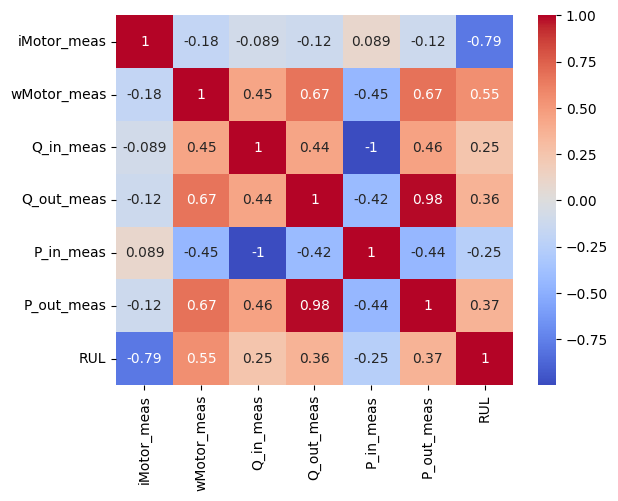

In [10]:
sns.heatmap(df[list(df.columns[4:-2]) + list(df.columns[-1:])].corr(), annot=True, cmap='coolwarm')
plt.show()

In [11]:
iMotor, wMotor, Q_in, Q_out, P_in, P_out, t = df['iMotor_meas'], df['wMotor_meas'], df['Q_in_meas'], df['Q_out_meas'], df['P_in_meas'], df['P_out_meas'], df['simulation_time'] 

['None' 'WornBearing']


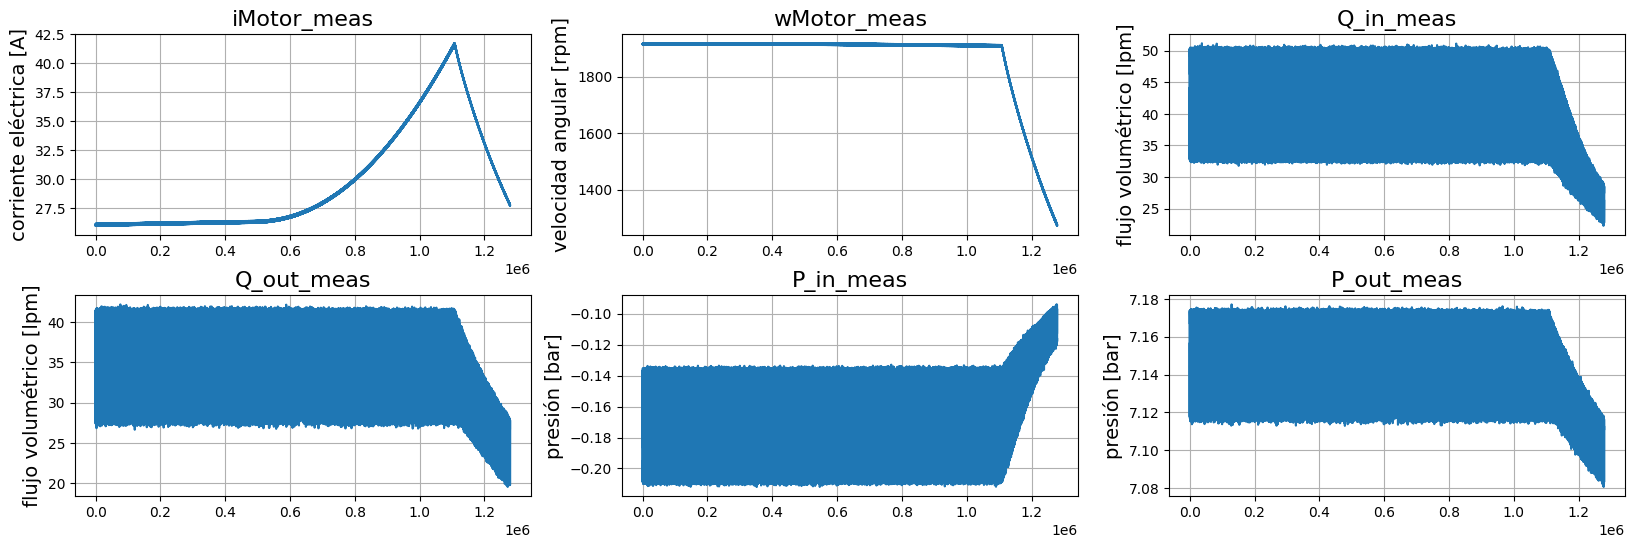

In [12]:
print(df['failure_mode'].unique())

title_size = 16
body_size = 14
y_axis_values = 4

plt.figure(figsize=(20, 6))
plt.subplot(2, 3, 1)
plt.plot(iMotor, '-')
plt.title('iMotor_meas', fontsize=title_size)
plt.ylabel('corriente eléctrica [A]', fontsize=body_size)
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(wMotor, '-')
plt.title('wMotor_meas', fontsize=title_size)
plt.ylabel('velocidad angular [rpm]', fontsize=body_size)
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(Q_in, '-')
plt.title('Q_in_meas', fontsize=title_size)
plt.ylabel('flujo volumétrico [lpm]', fontsize=body_size)
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(Q_out, '-')
plt.title('Q_out_meas', fontsize=title_size)
plt.ylabel('flujo volumétrico [lpm]', fontsize=body_size)
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(P_in, '-')
plt.title('P_in_meas', fontsize=title_size)
plt.ylabel('presión [bar]', fontsize=body_size)
plt.grid(True)

plt.subplot(2, 3, 6)
plt.plot(P_out, '-')
plt.title('P_out_meas', fontsize=title_size)
plt.ylabel('presión [bar]', fontsize=body_size)
plt.grid(True)

plt.subplots_adjust(hspace=0.3, wspace=0.2)

## Suavizado de curvas con Exponential Smoothing

Suavizado pata atenuar los efectos del ruido y resaltar características importantes

In [13]:
def exponential_smoothing(df, alpha):
    df_es = df.ewm(alpha=alpha).mean()
    return df_es
    
df_es = exponential_smoothing(df.iloc[:, 4:-2], 0.3)     #Window size = 10 value points

In [14]:
iMotor_es, wMotor_es, Q_in_es, Q_out_es, P_in_es, P_out_es = df_es['iMotor_meas'], df_es['wMotor_meas'], df_es['Q_in_meas'], df_es['Q_out_meas'], df_es['P_in_meas'], df_es['P_out_meas'] 

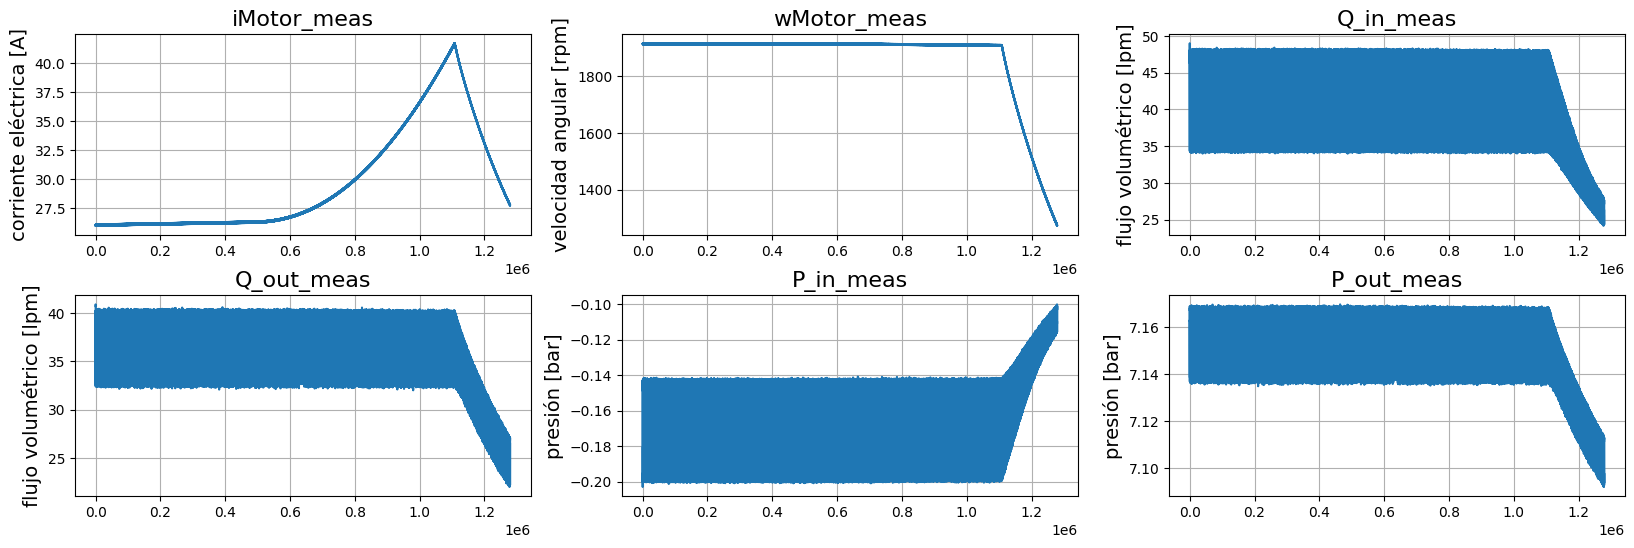

In [15]:
title_size = 16
body_size = 14
y_axis_values = 4

plt.figure(figsize=(20, 6))
plt.subplot(2, 3, 1)
plt.plot(iMotor_es, '-')
plt.title('iMotor_meas', fontsize=title_size)
plt.ylabel('corriente eléctrica [A]', fontsize=body_size)
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(wMotor_es, '-')
plt.title('wMotor_meas', fontsize=title_size)
plt.ylabel('velocidad angular [rpm]', fontsize=body_size)
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(Q_in_es, '-')
plt.title('Q_in_meas', fontsize=title_size)
plt.ylabel('flujo volumétrico [lpm]', fontsize=body_size)
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(Q_out_es, '-')
plt.title('Q_out_meas', fontsize=title_size)
plt.ylabel('flujo volumétrico [lpm]', fontsize=body_size)
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(P_in_es, '-')
plt.title('P_in_meas', fontsize=title_size)
plt.ylabel('presión [bar]', fontsize=body_size)
plt.grid(True)

plt.subplot(2, 3, 6)
plt.plot(P_out_es, '-')
plt.title('P_out_meas', fontsize=title_size)
plt.ylabel('presión [bar]', fontsize=body_size)
plt.grid(True)

plt.subplots_adjust(hspace=0.3, wspace=0.2)

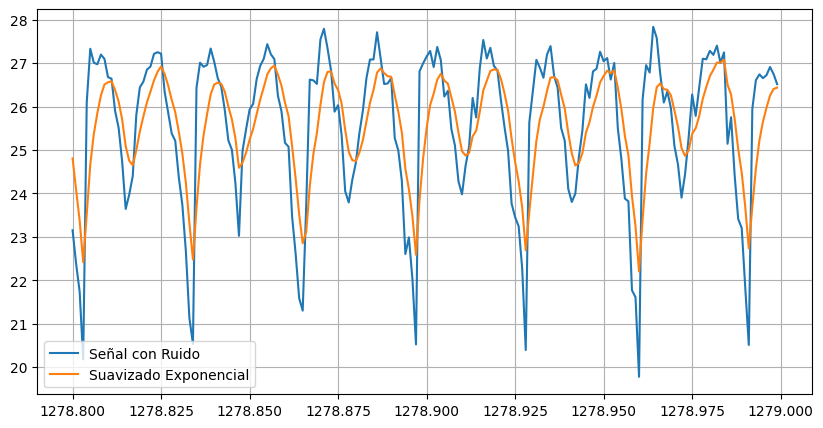

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(t.tail(200), Q_out.tail(200), '-', linewidth=1.5, label='Señal con Ruido')
plt.plot(t.tail(200), Q_out_es.tail(200), '-', linewidth=1.5, label='Suavizado Exponencial')
plt.legend(loc='lower left')
plt.grid(True)
plt.savefig('images/exp_smooth.png', format='png', dpi=300)

## Suavizado Exponencial Simple

El suavizado esponencial asigna pesos decrecientes exponecialmente a los datos pasados. Los datos más recientes son los que tienen un peso mayor en el promedio suavizado. La fórmula típica para el suavizado esponencial simple es:

$$
S_{t} = \alpha X_{t} + (1 - \alpha) S_{t-1}
$$

donde $S_{t}$ es el valor suavizado en el tiempo $t$, $X_{t}$ es el valor original en el tiempo $t$, y $\alpha$ es el factor de suavizado $(0 < \alpha < 1)$. Este método introduce menos retraso en la serie temporal que la media móvil y es lo suficientemente flexible como para ajustarse para capturar tendencias y patrones en los datos, pero es más adecuado para datos sin una tendencia clara o un patrón estacional fuerte. Por otro lado, el método es bastante sensible al valor del factor de suavizado $\alpha$, lo cual puede afectar en granmedida la calidad del suavizado. Este método es adecuado para datos sin una tendencia clara o un patrón estacional.

La función de suavizado exponencial `exponential_smoothing(df, alpha)` utilizada, toma como argumento de entrada el parámetro `alpha`, para el cual se estima un valor de 0.3, ya que la inspección visual indica un buen nivel de suavizado con eliminación del ruido, pero sin pérdida de la información más relevante. 

In [ ]:
for i in range(9):
    with open('../sensored_signals/B0xx_sensored_signals/' + 'B00'+str(i+1)+'.pkl', 'rb') as f:
        df = pickle.load(f)
    exp_df = exponential_smoothing(df.iloc[:, 4:-2], 0.3) 
    df.iloc[:, 4:-2] = exp_df
    df.to_pickle('B0xx_smoothed_data/' + 'exp_smooth_'+'B00'+str(i+1)+'.pkl')
for i in range(9, 14):
    with open('../sensored_signals/B0xx_sensored_signals/' + 'B0'+str(i+1)+'.pkl', 'rb') as f:
        df = pickle.load(f)
    exp_df = exponential_smoothing(df.iloc[:, 4:-2], 0.3) 
    df.iloc[:, 4:-2] = exp_df
    df.to_pickle('B0xx_smoothed_data/' + 'exp_smooth_'+'B0'+str(i+1)+'.pkl')

## Feature Engineering

In [17]:
##### Time domain feature

def TD_features(x):
    mean = x.mean().iloc[0]
    median = np.median(x)
    std = x.std().iloc[0]
    var = x.var().iloc[0]
    max_value = np.max(x)
    min_value = np.min(x)
    peak_value = np.max(abs(x))
    rms = np.sqrt(np.mean(x**2))
    kurtosis = x.kurtosis().iloc[0]
    skewness = x.skew().iloc[0]
    crest_factor = peak_value / rms
    shape_factor = rms / np.mean(abs(x))
    impulse_factor = peak_value / np.mean(abs(x))
    clearence_factor = peak_value / np.mean(abs(x)**0.5)**2
    return [mean, median, std, var, max_value, min_value, rms, kurtosis, skewness, crest_factor, shape_factor, impulse_factor, clearence_factor]

#### Compute spectrum from Fourier Transform
We first need a formula for the discrete-time Fourier transform of the data x:
$$
X_{j} = \sum_{n=1}^{N} x_{n}\cdot \exp(-i2\pi f_{j} t_{n})
$$
The Fourier transform computes the sum over all the time indices $t_{n} = \Delta\{1, 2, 3, ..., N \}$ of the data $x_{n}$  multiplied by sinusoids oscillating at a given frequency $f_{j} = j/T$, where $j = \{-N/2+1, -N/2+2, ..., -N/2-1, -N/2-2\}$. The result is a new quantity $X_{j}$, the signal as a function of frequency $f_{j}$ rather than time $t_{n}$. The spectrum is then:
$$
S_{xx, j}=\frac{2\Delta^{2}}{T}\cdot |X_{j}|^{2}
$$
which is the product of the Fourier transfrom of $x$ with its complex conjugate (indicated by the superscript ∗), scaled by the sampling interval and the total duration of the recording. The term $2\Delta^{2}/T$ is simply a numerical scaling. 

One technique to emphasize lower-amplitude rhythms hidden by large-amplitude oscillations is to change the scale of the spectrum to decibels. The decibel is a logarithmic scale and easily computed as follows:
To further emphasize the low-frequency structure of the spectrum, we may also convert the frequency axis to a logarithmic scale:

In [18]:
##### Frequency domain feature

def PowerSpectrum(x, dt, N):
    freqs = np.fft.fftfreq(N, dt)
    idx = np.argsort(freqs)
    fd = pd.DataFrame(freqs[idx][int(N/2):], columns=['Freq [Hz]'])  # Bandas de frecuencia de 0 a Nyquist
    fft_values = np.fft.fft(x.values.flatten())
    ps = (1 / N**2) * np.abs(fft_values)**2  # Espectro de Potencia
    ps = ps[:int(N/2)]
    ps[1:-1] = 2 * ps[1:-1]  # Doblar los valores excepto DC y Nyquist
    ps_dB = 10 * np.log10(ps)
    ps_dB = pd.DataFrame(ps_dB, columns=[f'{x.columns[0]}_PS_dB'])
    return [ps_dB, fd]

def FD_features(xf, f):
    freq_center = sum(abs(xf[xf.columns[0]]) * f[f.columns[0]]) / sum(abs(xf[xf.columns[0]]))
    rms_freq = np.sqrt(sum(abs(xf[xf.columns[0]])**2 * f[f.columns[0]]**2) / sum(abs(xf[xf.columns[0]])**2))
    std_freq = np.sqrt(sum(abs(xf[xf.columns[0]]) * (f[f.columns[0]] - freq_center)**2) / sum(abs(xf[xf.columns[0]])))
    RSPPB = abs(xf).max().iloc[0] / abs(xf).mean().iloc[0] 
    spectral_kurtosis = kurtosis(xf.values.flatten())
    spectral_skewness = skew(xf.values.flatten())
    return [freq_center, rms_freq, std_freq, RSPPB, spectral_kurtosis, spectral_skewness]

In [19]:
#### Other useful features
def other_features(x):
    slope = np.polyfit(np.array(x.index), x.values.flatten(), 1)[0]
    first_derivative = np.mean(np.diff(x.values.flatten()) / np.diff(np.array(x.index)))
    second_derivative = np.mean(np.diff(np.diff(x.values.flatten()) / np.diff(np.array(x.index))) / np.diff(np.array(x.index)[:-1]))
    return [slope, first_derivative, second_derivative]

## Feature Generation

In [20]:
def process_window(data, window_size, time_point):
    unit_id = data['unit_id'].unique()
    failure_mode = data['failure_mode'].unique()
    RUL = data['RUL'].unique()
    features = pd.DataFrame([unit_id, failure_mode, RUL], index=['unit_id', 'failure_mode', 'RUL']).T
    num_windows = data.shape[0] // window_size
    win_features = pd.DataFrame()
    for k in range(num_windows):
        sub_features = features
        for j in range(4, 10):
            x = data.iloc[:, j:j+1].astype(float)
            ps_dB, fd = PowerSpectrum(x, 1/len(x), len(x))
            sub_x = x.iloc[k * window_size : (k+1) * window_size]
            sub_ps_dB, sub_fd = ps_dB.iloc[k * int(window_size/2) : (k+1) * int(window_size/2)], fd.iloc[k * int(window_size/2) : (k+1) * int(window_size/2)]
            td_features = pd.DataFrame(TD_features(sub_x)).T
            td_features.columns = [
                f'mean_{x.columns[0]}', f'median_{x.columns[0]}', f'std_{x.columns[0]}', f'var_{x.columns[0]}',
                f'max_value_{x.columns[0]}', f'min_value_{x.columns[0]}', f'rms_{x.columns[0]}', f'kurtosis_{x.columns[0]}', 
                f'skewness_{x.columns[0]}',  f'crest_factor_{x.columns[0]}', f'shape_factor_{x.columns[0]}', 
                f'impulse_factor_{x.columns[0]}', f'clearence_factor_{x.columns[0]}'
            ]
            fd_features = pd.DataFrame(FD_features(sub_ps_dB, sub_fd)).T
            fd_features.columns = [
                f'freq_center_{ps_dB.columns[0]}', f'rms_freq_{ps_dB.columns[0]}', f'std_freq_{ps_dB.columns[0]}', 
                f'RSPPB_{ps_dB.columns[0]}', f'spectral_kurtosis_{ps_dB.columns[0]}', f'spectral_skewness_{ps_dB.columns[0]}'
            ]
            more_features = pd.DataFrame(other_features(sub_x)).T
            more_features.columns = [
                f'slope_{x.columns[0]}', f'first_derivative_{x.columns[0]}', f'second_derivative_{x.columns[0]}'
            ]
            sub_features = pd.concat([sub_features, td_features, fd_features, more_features], axis=1)
        win_features = pd.concat([win_features, sub_features], ignore_index=True)
    return win_features

def Get_features(df, window_size, n_jobs=-1):
    data_groups = df.groupby('time')
    time_points = df['time'].unique()
    results = Parallel(n_jobs=n_jobs)(delayed(process_window)(data_groups.get_group(time_point), window_size, time_point) for time_point in time_points)
    extracted_features = pd.concat(results, ignore_index=True)
    cols = list(extracted_features.columns)
    cols.append(cols.pop(cols.index('RUL')))
    extracted_features = extracted_features[cols]
    return extracted_features

In [53]:
for window_size in [1000]:
    rd_1 = pd.DataFrame()
    for i in range(9):
        with open('B0xx_smoothed_data/exp_smooth_B00'+str(i+1)+'.pkl', 'rb') as f:
            df = pickle.load(f)
        extracted_features = Get_features(df, window_size)
        rd_1 = pd.concat([rd_1, extracted_features], ignore_index=True)
    rd_2 = pd.DataFrame()
    for i in range(9, 14):
        with open('B0xx_smoothed_data/exp_smooth_B0'+str(i+1)+'.pkl', 'rb') as f:
            df = pickle.load(f)
        extracted_features = Get_features(df, window_size)
        rd_2 = pd.concat([rd_2, extracted_features], ignore_index=True)
    resized_data = pd.concat([rd_1, rd_2], ignore_index=True)

In [54]:
if resized_data.isna().any().any():
    print("El DataFrame contiene valores NaN")
else:
    print("El DataFrame no contiene valores NaN")
print('')
nans_por_columna = resized_data.isna().sum()
print(nans_por_columna[nans_por_columna > 0])
print('')
resized_data.info()

El DataFrame no contiene valores NaN

Series([], dtype: int64)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18690 entries, 0 to 18689
Columns: 135 entries, unit_id to RUL
dtypes: float64(132), object(3)
memory usage: 19.3+ MB


In [55]:
x = resized_data.iloc[:,2:-1]     #feature variables
y = resized_data.iloc[:,-1]       #target variable

## Feature Selection

In [14]:
#### Extremely Randomized Trees Regression 

etr = ExtraTreesRegressor(n_estimators=1000, n_jobs=-1)
etr = etr.fit(x, y)
importances = etr.feature_importances_
feature_importances_etr = pd.DataFrame({'Feature': x.columns, 'Importance': importances})
feature_importances_etr = feature_importances_etr.sort_values(by='Importance', ascending=False)
feature_importances_etr = feature_importances_etr.reset_index(drop=True)
feature_importances_etr['Cumulative'] = feature_importances_etr['Importance'].cumsum()
feature_importances_etr['Cumulative'] = (feature_importances_etr['Cumulative'] / feature_importances_etr['Importance'].sum()) * 100

C:\Users\ignac\AppData\Local\Temp\ipykernel_25476\1598621574.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([f'{x:.0f}%' for x in yticks])


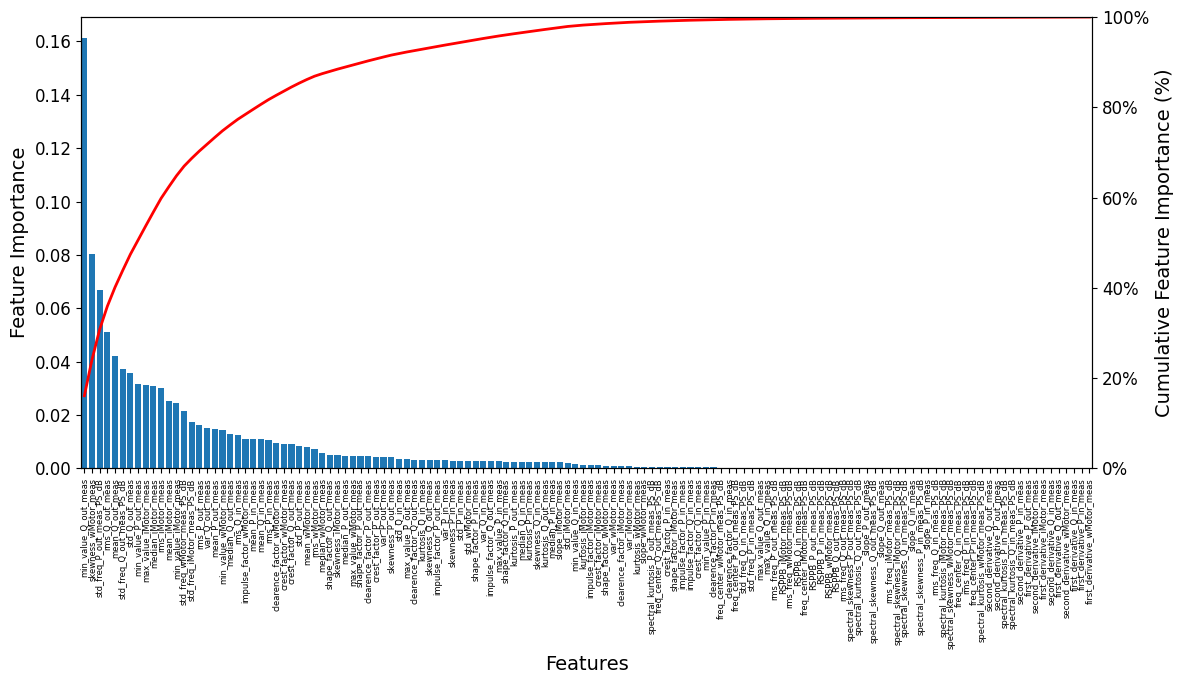

In [31]:
VERY_SMALL_SIZE = 6
SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

# Aplicamos los tamaños de fuente globalmente
plt.rc('font', size=SMALL_SIZE)          # controles por defecto
plt.rc('axes', titlesize=LARGE_SIZE)     # tamaño de los títulos de los ejes
plt.rc('axes', labelsize=MEDIUM_SIZE)    # tamaño de las etiquetas x e y
plt.rc('xtick', labelsize=SMALL_SIZE)    # tamaño de las etiquetas del eje x
plt.rc('ytick', labelsize=SMALL_SIZE)    # tamaño de las etiquetas del eje y
plt.rc('legend', fontsize=SMALL_SIZE)    # tamaño de la leyenda
plt.rc('figure', titlesize=LARGE_SIZE)   # tamaño del título de la figura

fig, ax1 = plt.subplots(figsize=(12, 7))
n_features = len(feature_importances_etr['Feature'])
ax1.bar(x=np.arange(len(feature_importances_etr['Feature'])), height=feature_importances_etr['Importance'], tick_label=feature_importances_etr['Feature'])
plt.xticks(rotation=90, fontsize=VERY_SMALL_SIZE)
ax1.set_ylabel('Feature Importance')
ax1.set_xlabel('Features')
ax1.set_xlim(-0.5, n_features - 0.5)
ax2 = ax1.twinx()
ax2.plot(np.arange(len(feature_importances_etr['Feature'])), feature_importances_etr['Cumulative'], color='red', linewidth=2)
ax2.set_ylabel('Cumulative Feature Importance (%)')
ax2.set_ylim(0, 100)
yticks = ax2.get_yticks()
ax2.set_yticklabels([f'{x:.0f}%' for x in yticks])
ax1.autoscale(enable=True, axis='x', tight=True)
ax2.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()
plt.savefig('images/feature_importances.png', format='png', dpi=300) 
plt.show()

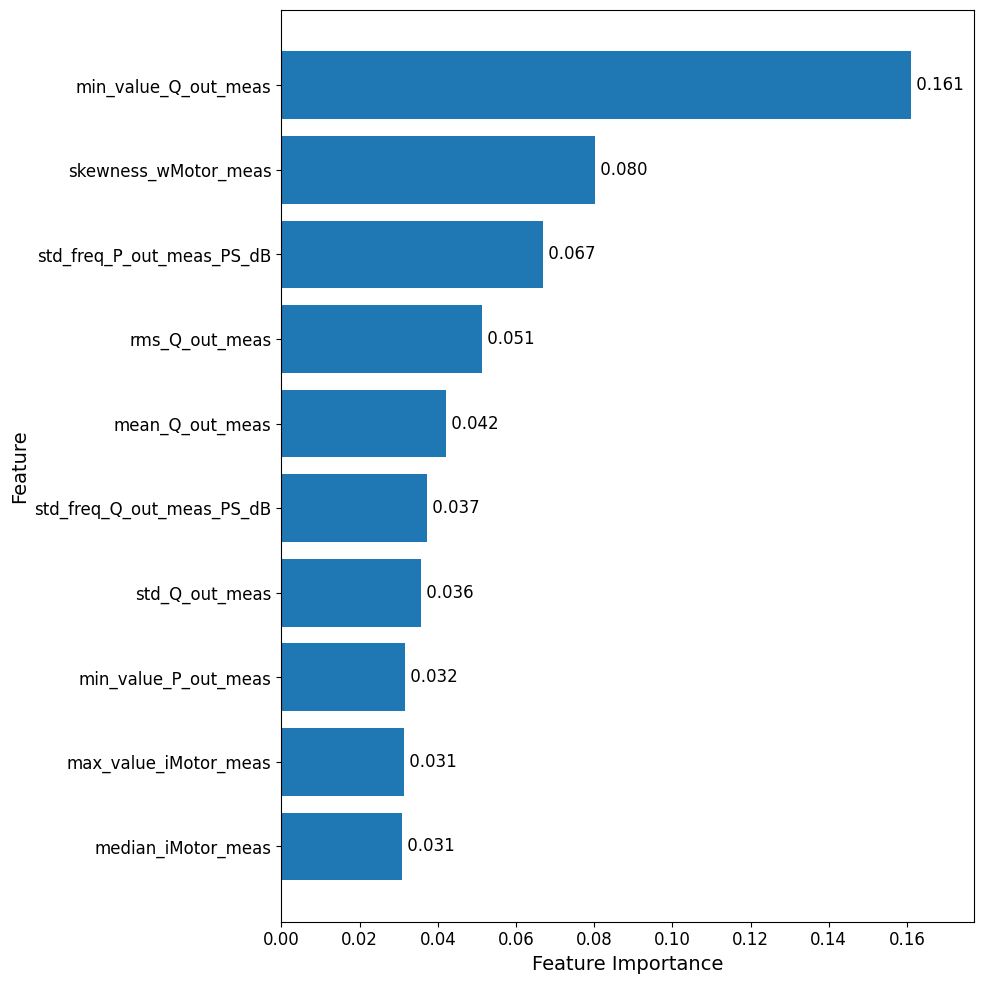

In [41]:
top_10_features = feature_importances_etr.sort_values('Importance', ascending=False).head(10)
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=LARGE_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=LARGE_SIZE)
fig, ax1 = plt.subplots(figsize=(10, 10))
bars = ax1.barh(y=np.arange(10), width=top_10_features['Importance'],  tick_label=top_10_features['Feature'])
plt.yticks(fontsize=SMALL_SIZE)
ax1.set_xlabel('Feature Importance')
ax1.set_ylabel('Feature')
ax1.invert_yaxis()
for i, v in enumerate(top_10_features['Importance']):
    ax1.text(v, i, f' {v:.3f}', va='center')
ax1.set_xlim(0, max(top_10_features['Importance']) * 1.1)
plt.tight_layout()
plt.savefig('images/top_ten_features.png', format='png', dpi=300) 
plt.show()

In [24]:
num_features = np.where(cumulative_importances_etr >= 0.95)[0][0] + 1    #### Se seleccionan las features que explican el 95% de la importancia
etr_features = feature_importances_etr['Feature'][:num_features]
print('Number o features selected: ', len(list(etr_features.values)))
print('')
print('Features Selected: ', list(etr_features.values))

Number o features selected:  52

Features Selected:  ['min_value_Q_out_meas', 'skewness_wMotor_meas', 'std_freq_P_out_meas_PS_dB', 'rms_Q_out_meas', 'mean_Q_out_meas', 'std_Q_out_meas', 'std_freq_Q_out_meas_PS_dB', 'max_value_iMotor_meas', 'min_value_P_out_meas', 'mean_iMotor_meas', 'median_iMotor_meas', 'std_freq_iMotor_meas_PS_dB', 'rms_iMotor_meas', 'min_value_iMotor_meas', 'std_freq_wMotor_meas_PS_dB', 'min_value_wMotor_meas', 'rms_P_out_meas', 'var_Q_out_meas', 'mean_P_out_meas', 'median_Q_out_meas', 'mean_P_in_meas', 'rms_P_in_meas', 'mean_Q_in_meas', 'std_P_out_meas', 'rms_Q_in_meas', 'impulse_factor_wMotor_meas', 'crest_factor_wMotor_meas', 'rms_wMotor_meas', 'clearence_factor_wMotor_meas', 'median_wMotor_meas', 'mean_wMotor_meas', 'crest_factor_Q_out_meas', 'crest_factor_P_out_meas', 'clearence_factor_Q_out_meas', 'var_P_out_meas', 'std_wMotor_meas', 'shape_factor_Q_out_meas', 'skewness_iMotor_meas', 'max_value_wMotor_meas', 'median_P_out_meas', 'skewness_P_out_meas', 'impulse

In [25]:
####  Gradient Boosting
"""El algoritmo de Gradient Boosting también puede ser utilizado para evaluar la importancia de las características."""

gbr = GradientBoostingRegressor(n_estimators=1000)
gbr = gbr.fit(x, y)
importances = gbr.feature_importances_
feature_importances_gbr = pd.DataFrame({'Feature': x.columns, 'Importance': importances})
feature_importances_gbr = feature_importances_gbr.sort_values(by='Importance', ascending=False)
feature_importances_gbr = feature_importances_gbr.reset_index(drop=True)
cumulative_importances_gbr = feature_importances_gbr['Importance'].cumsum()

In [26]:
num_features = np.where(cumulative_importances_gbr >= 0.95)[0][0] + 1    #### Se seleccionan las features que explican el 95% de la importancia
gbr_features = feature_importances_gbr['Feature'][:num_features]
print('Number o features selected: ', len(list(gbr_features.values)))
print('')
print('Features Selected: ', list(gbr_features.values))

Number o features selected:  14

Features Selected:  ['min_value_wMotor_meas', 'rms_Q_out_meas', 'max_value_iMotor_meas', 'rms_P_out_meas', 'min_value_iMotor_meas', 'std_freq_P_out_meas_PS_dB', 'max_value_P_out_meas', 'median_iMotor_meas', 'mean_iMotor_meas', 'skewness_iMotor_meas', 'rms_iMotor_meas', 'median_P_in_meas', 'mean_wMotor_meas', 'median_Q_in_meas']


In [27]:
#### Random Forest
"""Random Forest es otra técnica basada en árboles que puede ser utilizada para evaluar la importancia de las características."""

rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
rf = rf.fit(x, y)
importances = rf.feature_importances_
feature_importances_rf = pd.DataFrame({'Feature': x.columns, 'Importance': importances})
feature_importances_rf = feature_importances_rf.sort_values(by='Importance', ascending=False)
feature_importances_rf = feature_importances_rf.reset_index(drop=True)
cumulative_importances_rf = feature_importances_rf['Importance'].cumsum()

In [30]:
num_features = np.where(cumulative_importances_rf >= 0.95)[0][0] + 1    #### Se seleccionan las features que explican el 95% de la importancia
rfr_features = feature_importances_rf['Feature'][:num_features]
print('Number o features selected: ', len(list(rfr_features.values)))
print('')
print('Features Selected: ', list(rfr_features.values))

Number o features selected:  13

Features Selected:  ['min_value_wMotor_meas', 'max_value_iMotor_meas', 'rms_Q_out_meas', 'mean_Q_out_meas', 'max_value_P_out_meas', 'rms_P_out_meas', 'mean_P_out_meas', 'min_value_iMotor_meas', 'mean_iMotor_meas', 'rms_iMotor_meas', 'median_Q_in_meas', 'skewness_iMotor_meas', 'median_iMotor_meas']


## Votación y Comparación de las Características Seleccionadas

La idea detrás de la votación y comparación de las características es combinar los resultados de múltiples métodos de selección de características para identificar aquellas que son consistentes y relevantes a través de diferentes enfoques. A continuación, se detalla el proceso en profundidad. Un forma de seleccionar las características es calcular el promedio de las importancias de cada característica a través de los métodos que proporcionan importancias (por ejemplo, ExtraTrees, Gradient Boosting, Random Forest). Esto puede hacerse normalizando las importancias de cada método y luego promediándolas.

In [49]:
importance_dfs = [feature_importances_etr, feature_importances_gbr, feature_importances_rf]
aligned_importances = [df.set_index('Feature') for df in importance_dfs]
all_importances = pd.concat(aligned_importances, axis=1).fillna(0)
all_importances['Average'] = all_importances.mean(axis=1)
average_importance_threshold = all_importances['Average'].mean()
selected_features_by_average = all_importances[all_importances['Average'] > average_importance_threshold].index.tolist()
print('Number o features selected: ', len(selected_features_by_average), 'for all forests-based methods')
print('')
print('Features Selected: ', selected_features_by_average)

Number o features selected:  19 for all forests-based methods

Features Selected:  ['min_value_Q_out_meas', 'skewness_wMotor_meas', 'std_freq_P_out_meas_PS_dB', 'rms_Q_out_meas', 'mean_Q_out_meas', 'std_Q_out_meas', 'std_freq_Q_out_meas_PS_dB', 'max_value_iMotor_meas', 'min_value_P_out_meas', 'mean_iMotor_meas', 'median_iMotor_meas', 'std_freq_iMotor_meas_PS_dB', 'rms_iMotor_meas', 'min_value_iMotor_meas', 'std_freq_wMotor_meas_PS_dB', 'min_value_wMotor_meas', 'rms_P_out_meas', 'mean_P_out_meas', 'max_value_P_out_meas']


Luego, se seleccionan las 10 variables que mejor explican el RUL según los métodos de selección basados en árboles de decisión usados en el preprocesamiento. La selección de sólo 10 variables es completamente arbitraria en este caso.

In [31]:
# top 10 features selected
selected_features = selected_features_by_average[:10]
resized_data = pd.concat([resized_data[['unit_id', 'failure_mode']], resized_data[selected_features], resized_data['RUL']], axis=1)
resized_data

,unit_id,failure_mode,min_value_Q_out_meas,skewness_wMotor_meas,std_freq_P_out_meas_PS_dB,rms_Q_out_meas,mean_Q_out_meas,std_Q_out_meas,std_freq_Q_out_meas_PS_dB,max_value_iMotor_meas,min_value_P_out_meas,mean_iMotor_meas,RUL
0,B001,None,32.394284,-0.760565,143.713066,38.157067,38.122848,1.616421,141.862478,26.129583,7.136748,26.066233,1278
1,B001,None,32.478709,-0.762235,143.185347,38.164528,38.130851,1.603732,142.011287,26.129963,7.136172,26.066699,1277
2,B001,None,32.329670,-0.760916,143.691910,38.162943,38.129223,1.604738,142.280636,26.132266,7.136282,26.067715,1276
3,B001,None,32.477976,-0.765591,143.551849,38.173955,38.140021,1.610034,141.406634,26.132524,7.136346,26.068346,1275
4,B001,None,32.430556,-0.758541,143.877534,38.161931,38.128119,1.606882,142.109985,26.132659,7.136378,26.068827,1274
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18685,B014,WornBearing_LeakSeal_BlockedIn,-0.224204,-0.049157,138.356185,18.492497,12.300133,13.815573,132.598554,40.755202,6.422561,39.480123,4
18686,B014,WornBearing_LeakSeal_BlockedIn,-0.245805,-0.054307,141.266916,18.469910,12.213984,13.861758,134.173321,40.719535,6.420044,39.444719,3
18687,B014,WornBearing_LeakSeal_BlockedIn,-0.257207,-0.053952,139.115263,18.488687,12.187343,13.910202,134.150505,40.678750,6.419261,39.403116,2
18688,B014,WornBearing_LeakSeal_BlockedIn,-0.298515,-0.056487,141.991941,18.463381,12.123736,13.932178,137.071734,40.629666,6.416488,39.353773,1


## Piece-Wise RUL

Aplicamos un RUL picewise definido anteriormente dado que los sistemas en la práctica real no muestran una tendencia clara antes de la falla, por lo que en lugar de usar una recta usamos una función por partes

In [52]:
EOL = [1279, 1169, 1418, 1200, 1292, 1462, 1431, 1135, 1252, 1318, 1519, 1431, 1475, 1309]
ts = [479, 370, 619, 401, 493, 663, 632, 335, 453, 519, 719, 632, 676, 510]
RULs = pd.DataFrame()
for i in range(len(EOL)):
    t_s = ts[i]
    t_EOL = EOL[i]
    time = np.arange(0, t_EOL)
    a = -(t_EOL - 1 ) / (t_EOL - t_s)
    RUL = pd.DataFrame(np.piecewise(time, [time <= t_s, time > t_s], [(t_EOL - 1 ), lambda t: a * (t - t_s) + (t_EOL - 1 )]), columns=['RUL'])
    RULs = pd.concat([RULs, RUL], axis=0).reset_index(drop=True)
resized_data['RUL'] = RULs['RUL']
resized_data.to_pickle('resized_data.pkl')

In [33]:
resized_data

,unit_id,failure_mode,min_value_Q_out_meas,skewness_wMotor_meas,std_freq_P_out_meas_PS_dB,rms_Q_out_meas,mean_Q_out_meas,std_Q_out_meas,std_freq_Q_out_meas_PS_dB,max_value_iMotor_meas,min_value_P_out_meas,mean_iMotor_meas,RUL
0,B001,None,32.394284,-0.760565,143.713066,38.157067,38.122848,1.616421,141.862478,26.129583,7.136748,26.066233,1278
1,B001,None,32.478709,-0.762235,143.185347,38.164528,38.130851,1.603732,142.011287,26.129963,7.136172,26.066699,1278
2,B001,None,32.329670,-0.760916,143.691910,38.162943,38.129223,1.604738,142.280636,26.132266,7.136282,26.067715,1278
3,B001,None,32.477976,-0.765591,143.551849,38.173955,38.140021,1.610034,141.406634,26.132524,7.136346,26.068346,1278
4,B001,None,32.430556,-0.758541,143.877534,38.161931,38.128119,1.606882,142.109985,26.132659,7.136378,26.068827,1278
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18685,B014,WornBearing_LeakSeal_BlockedIn,-0.224204,-0.049157,138.356185,18.492497,12.300133,13.815573,132.598554,40.755202,6.422561,39.480123,8
18686,B014,WornBearing_LeakSeal_BlockedIn,-0.245805,-0.054307,141.266916,18.469910,12.213984,13.861758,134.173321,40.719535,6.420044,39.444719,6
18687,B014,WornBearing_LeakSeal_BlockedIn,-0.257207,-0.053952,139.115263,18.488687,12.187343,13.910202,134.150505,40.678750,6.419261,39.403116,4
18688,B014,WornBearing_LeakSeal_BlockedIn,-0.298515,-0.056487,141.991941,18.463381,12.123736,13.932178,137.071734,40.629666,6.416488,39.353773,3


## Funciones de Sliding Window y Normalización de los datos con MinMaxScaler

In [38]:
def Scaler(df):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    features = np.array(df_scaled[:, :-1]) 
    target = np.array(df_scaled[:,-1])
    return [features, target, scaler]

def Sliding_Window(features, target, win_length):    
    ts_generator = TimeseriesGenerator(features, target, length=win_length, sampling_rate=1, batch_size=1) 
    X=[]
    y=[]
    for i in range(len(ts_generator)):
        x_temp, y_temp = ts_generator[i]
        X.append(x_temp.reshape(x_temp.shape[1], x_temp.shape[2], 1))
        y.append(y_temp)
    X=np.array(X)  
    y=np.array(y)
    return [X, y]

## Remuestreo y Escalado de datos 

In [39]:
def Resampler_and_Escaler(df, selected_features, win_length, esc):
    features = len(selected_features)
    input_shape = (win_length, features)
    
    train_units = df[df['unit_id'].isin(escenarios[esc]['train_units'])].reset_index(drop=True)
    features_train = []
    target_train = []
    for unit in train_units['unit_id'].unique():
        features, target, scaler = Scaler(train_units[train_units['unit_id']==unit].iloc[:, 2:])
        features_train.append(features)
        target_train.append(target)
    features_train = np.concatenate(features_train, axis=0)
    target_train = np.concatenate(target_train, axis=0)
        
    val_units = df[df['unit_id'].isin(escenarios[esc]['val_units'])].reset_index(drop=True)
    features_val = []
    target_val = []
    for unit in val_units['unit_id'].unique():
        features, target, scaler = Scaler(val_units[val_units['unit_id']==unit].iloc[:, 2:])
        features_val.append(features)
        target_val.append(target)
    features_val = np.concatenate(features_val, axis=0)
    target_val = np.concatenate(target_val, axis=0)
    
    test_units = df[df['unit_id'].isin(escenarios[esc]['test_units'])].reset_index(drop=True)
    features_test = []
    target_test = []
    for unit in test_units['unit_id'].unique():
        features, target, scaler = Scaler(test_units[test_units['unit_id']==unit].iloc[:, 2:])
        features_test.append(features)
        target_test.append(target)
    features_test = np.concatenate(features_test, axis=0)
    target_test = np.concatenate(target_test, axis=0)
    
    x_train, y_train = Sliding_Window(features_train, target_train, win_length)
    x_val, y_val = Sliding_Window(features_val, target_val, win_length)
    x_test, y_test = Sliding_Window(features_test, target_test, win_length)

    return input_shape, x_train, y_train, x_val, y_val, x_test, y_test

## Definición de escenarios de entrenamiento

Justificación:
* Esta separación evalúa la capacidad del modelo para generalizar a modos de falla completamente nuevos.
* El conjunto de validación ayuda a ajustar el modelo para no sobreajustarse a los modos de falla específicos del conjunto de entrenamiento.
* El conjunto de prueba evalúa cómo el modelo se comporta con modos de falla que nunca ha visto.

In [40]:
escenarios = {
    1:{
        'train_units':['B001', 'B002', 'B003', 'B004', 'B005', 'B006', 'B009'], 
        'val_units':['B010', 'B011', 'B012'], 
        'test_units':['B007', 'B008', 'B013', 'B014']
    }, 
    2:{
        'train_units':['B001', 'B003', 'B004', 'B006', 'B007', 'B010', 'B012', 'B013'], 
        'val_units':['B002', 'B011'], 
        'test_units':['B005', 'B008', 'B009', 'B014']
    }
}

## Se generan y guardan los conjuntos de datos finales para el entrenamiento

In [49]:
"""Conjuntos de datos del escenario #1"""

input_shape, x_train, y_train, x_val, y_val, x_test, y_test = Resampler_and_Escaler(resized_data, selected_features, 24, 1)
escenario_1_data = [input_shape, x_train, y_train, x_val, y_val, x_test, y_test]
with open('final_train_data/escenario_1_data.pkl', 'wb') as f:
    pickle.dump(escenario_1_data, f)

In [50]:
"""Conjuntos de datos del escenario #2"""

input_shape, x_train, y_train, x_val, y_val, x_test, y_test = Resampler_and_Escaler(resized_data, selected_features, 24, 2)
escenario_2_data = [input_shape, x_train, y_train, x_val, y_val, x_test, y_test]
with open('final_train_data/escenario_2_data.pkl', 'wb') as f:
    pickle.dump(escenario_2_data, f)